In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from gnomad_db.database import gnomAD_DB
from pathlib import Path
from collections import Counter, defaultdict
from concurrent.futures import ThreadPoolExecutor
import tqdm
from multiprocessing import Pool


/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/gnomad_db/database.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
data_location = '/s/project/benchmark-lm/ssd-cache'
fasta = Path("/s/project/ml4rg_students/2025/project07/data/GRCh38.primary_assembly.genome.fa")
seqs = pd.read_csv("/s/project/ml4rg_students/2025/project07/group_2/data/seqs_2009.csv")

In [3]:
db = gnomAD_DB(data_location, gnomad_version="v4")

In [4]:
def prep(chrom, start, end):

    if isinstance(chrom, str) and chrom.lower().startswith("chr"):
        chrom = chrom[3:]
    
    db_region = db.get_info_for_interval(chrom=chrom, interval_start=start, interval_end = end, query="*")
    db_region = db_region[db_region['filter'] == 'PASS'] 

    interval_length = end - start
    db_region['len_ref'] = db_region['ref'].apply(len)
    db_region['len_alt'] = db_region['alt'].apply(len)  
    db_region['is_snv'] = (db_region['len_ref'] == 1) & (db_region['len_alt'] == 1)

    db_region = db_region[db_region['is_snv']]

    return db_region

In [7]:
seqs

,Chromosome,Start,End,seq,seq_len
0,chr1,63561,65570,TCATATCGATGGGCACCTTCTTTTTCTTAATTGTATCATACATTTT...,2009
1,chr1,922428,924437,GGGAGAAGACACAGACTTCAGGAGAGGAAGGCACAGGAACTCACTG...,2009
2,chr1,923938,925947,AAGTCCCCGCCGGGCGGGCGCGCGCCAGTGGACGCGGGTGCACGAC...,2009
3,chr1,958690,960699,AGATCGGGAAGAGATTTTTGCACAACTCACCAACATACGCTCCCTG...,2009
4,chr1,964528,966537,AGGTCCGCAGTGGGGCTGCGGGGAGGGGGGCGCGGGTCCGCAGTGG...,2009
...,...,...,...,...,...
30055,chr22,50577909,50579918,CGCCATCCTGGGGGTTGGTCGGCACCTAGGACGGGGGCAGATGGGT...,2009
30056,chr22,50582775,50584784,CGCCATGGCGCGGGCTCGACCGGGCCCCAGGCCAGGCTGCGCTCCG...,2009
30057,chr22,50627773,50629782,GGACATGGGACCGAGGGGTCTGTCCCAAGAGAGGGAGGGCTACTTG...,2009
30058,chr22,50627366,50629375,GCCCATCCGAACCGGGAGCCGGCCGGTCAGGAGGGCGGCCCTGCGG...,2009


In [44]:
def get_sevenmer_context(pos,start, sequence):
    central_pos = pos - start

    return sequence[central_pos - 3 : central_pos + 4]

In [18]:
columns = ['context', 'ref', 'alt', 'AF']
alfreq_df = pd.DataFrame(columns = columns)

for row_index, row in seqs.iterrows():

    gnomad_df = prep(row.Chromosome, row.Start + 3, row.End - 3)

    for _, genrow in gnomad_df.iterrows():
        pos = genrow.pos
        seven_mer = get_sevenmer_context(pos, row_index)
        ref = genrow.ref
        alt = genrow.alt
        alfreq = genrow.AF
        alfreq_df.loc[len(alfreq_df)] = [seven_mer, ref, alt, alfreq]


KeyboardInterrupt: 

In [45]:
columns = ['context', 'ref', 'alt', 'AF']
alfreq_df = pd.DataFrame(columns = columns)

all_alleles = {'A', 'C', 'G', 'T'}

total_rows = len(seqs)

for i, (row_index, row) in enumerate(seqs.iterrows(), 1):
    print(f'Processing row {i} of {total_rows} ({(i/total_rows)*100:.2f}%)', end='\r')

    start = seqs.iloc[row_index].Start
    sequence = seqs.iloc[row_index].seq

    gnomad_df = prep(row.Chromosome, row.Start + 3, row.End - 3)
    for pos, group in gnomad_df.groupby('pos'):
        seven_mer = get_sevenmer_context(pos, start, sequence)
        ref = None
        available_alleles = set()
        for _, rowalt in group.iterrows():
            ref = rowalt['ref']
            alt = rowalt['alt']
            available_alleles.add(str(alt))
            alfreq = rowalt['AF']
            alfreq_df.loc[len(alfreq_df)] = [seven_mer, ref, alt, alfreq]

        for allele in all_alleles - available_alleles:
            alfreq_df.loc[len(alfreq_df)] = [seven_mer, ref, allele, 0]


        

KeyboardInterrupt: 

All of the above was moved into the python script 'neutral_model_final.py'

In [3]:
alfreq_df = pd.read_csv('data/all_freq.csv')
alfreq_df

,context,ref,alt,AF
0,ATCGATG,C,A,0.000036
1,ATCGATG,C,C,0.000000
2,ATCGATG,C,G,0.000000
3,ATCGATG,C,T,0.000000
4,GATGGGC,T,C,0.000009
...,...,...,...,...
47273351,CCAAAGG,A,A,0.000000
47273352,AAAGGT,A,G,0.000007
47273353,AAAGGT,A,C,0.000000
47273354,AAAGGT,A,T,0.000000


In [4]:
alfreq_df['context_length'] = alfreq_df['context'].apply(len)
count_len = (alfreq_df['context_length'] == 6).sum()
print(count_len)

18920


In [5]:
alfreq_df = alfreq_df.rename(columns={'context':'sequence_context'})

In [6]:
mutation_rate_model_df = pd.read_csv('/s/project/ml4rg_students/2025/project07/relative_mutation_rate.tsv', sep='\t')
mutation_rate_model_df

,sequence_context,ref,alt,estimated_p_mutated
0,AAAAAAA,A,C,0.002696
1,AAAAAAC,A,C,0.003904
2,AAAAAAG,A,C,0.001344
3,AAAAAAT,A,C,0.002309
4,AAAAACA,A,C,0.002943
...,...,...,...,...
49145,ACAGAAA,G,T,0.002508
49146,TAAGAAA,G,T,0.002509
49147,GAAGAAA,G,T,0.004403
49148,CAAGAAA,G,T,0.003803


In [7]:
merged_neutral = pd.merge(mutation_rate_model_df, alfreq_df, on=['sequence_context', 'ref', 'alt'], how='inner')

In [8]:
merged_neural = merged_neutral[merged_neutral["ref"] != merged_neutral["alt"]]

In [12]:
ref = merged_neutral[merged_neutral["ref"] == merged_neutral["alt"]]

In [17]:
ref = alfreq_df[alfreq_df["ref"] != alfreq_df["alt"]]
print(ref)


         sequence_context ref alt        AF  context_length
0                 ATCGATG   C   A  0.000036               7
2                 ATCGATG   C   G  0.000000               7
3                 ATCGATG   C   T  0.000000               7
4                 GATGGGC   T   C  0.000009               7
5                 GATGGGC   T   G  0.000000               7
...                   ...  ..  ..       ...             ...
47273349          CCAAAGG   A   C  0.000000               7
47273350          CCAAAGG   A   T  0.000000               7
47273352           AAAGGT   A   G  0.000007               6
47273353           AAAGGT   A   C  0.000000               6
47273354           AAAGGT   A   T  0.000000               6

[35455017 rows x 5 columns]


In [13]:
print(ref)

Empty DataFrame
Columns: [sequence_context, ref, alt, estimated_p_mutated, AF, context_length]
Index: []


In [10]:
merged_neutral

,sequence_context,ref,alt,estimated_p_mutated,AF,context_length
0,AAAAAAA,A,C,0.002696,0.0,7
1,AAAAAAA,A,C,0.002696,0.0,7
2,AAAAAAA,A,C,0.002696,0.0,7
3,AAAAAAA,A,C,0.002696,0.0,7
4,AAAAAAA,A,C,0.002696,0.0,7
...,...,...,...,...,...,...
10072204,AAGGAAA,G,T,0.001937,0.0,7
10072205,AAGGAAA,G,T,0.001937,0.0,7
10072206,AAGGAAA,G,T,0.001937,0.0,7
10072207,AAGGAAA,G,T,0.001937,0.0,7


In [7]:
import seaborn as sns

In [10]:
print(merged_neutral['AF'].describe())

count    1.007221e+07
mean     1.240437e-03
std      2.434825e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.573500e-06
max      1.000000e+00
Name: AF, dtype: float64


In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(merged_neutral['AF'], kde=True)
plt.show()

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

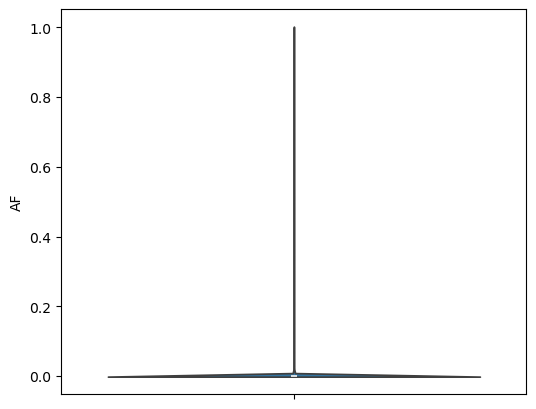

In [10]:
plt.figure(figsize=(6,5))
sns.violinplot(y=merged_neutral['AF'])
plt.show()

In [7]:
# Linear Regression
from sklearn.linear_model import LinearRegression

X = merged_neutral[['estimated_p_mutated']]
y = merged_neutral['AF']

model = LinearRegression()
model.fit(X,y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/scratch/tmp/s_igira/ipykernel_2257403/1879805237.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout() # Adjust layout to prevent labels from overlapping
/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


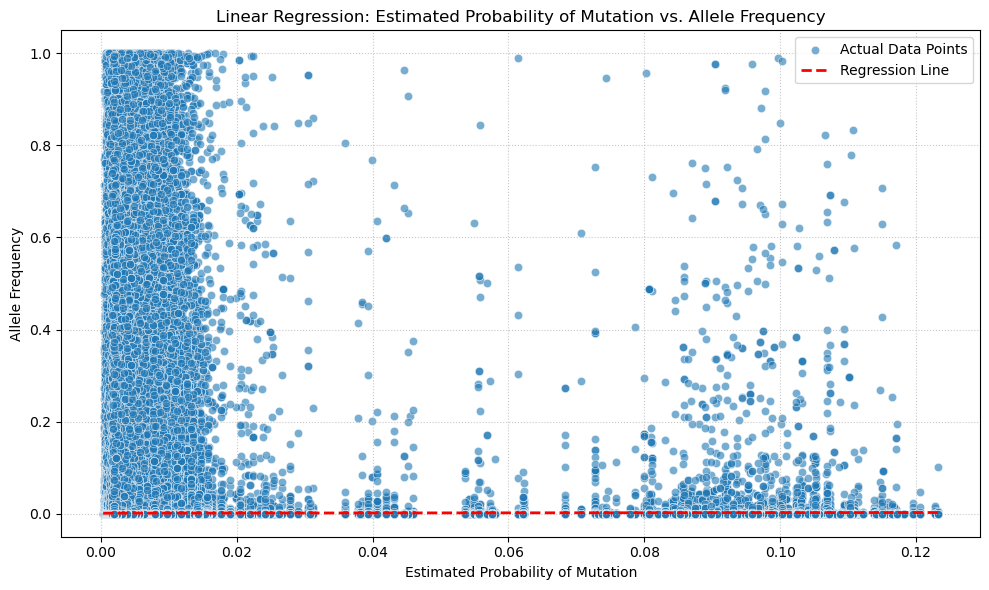

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

# 1. Create the scatter plot of the actual data points
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['estimated_p_mutated'], y=y, alpha=0.6, label='Actual Data Points')

# 2. Plot the regression line
# Get the minimum and maximum values of X to draw the line across the range
x_min = X['estimated_p_mutated'].min()
x_max = X['estimated_p_mutated'].max()

# Create a range of X values for prediction (e.g., 100 points between min and max)
x_line = np.linspace(x_min, x_max, 100).reshape(-1, 1)

# Predict y values for these X values using the trained model
y_line = model.predict(x_line)

# Plot the regression line
plt.plot(x_line, y_line, color='red', linestyle='--', linewidth=2, label='Regression Line')

# 3. Add labels and title
plt.title('Linear Regression: Estimated Probability of Mutation vs. Allele Frequency')
plt.xlabel('Estimated Probability of Mutation')
plt.ylabel('Allele Frequency')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


/scratch/tmp/s_igira/ipykernel_2257403/1533729183.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


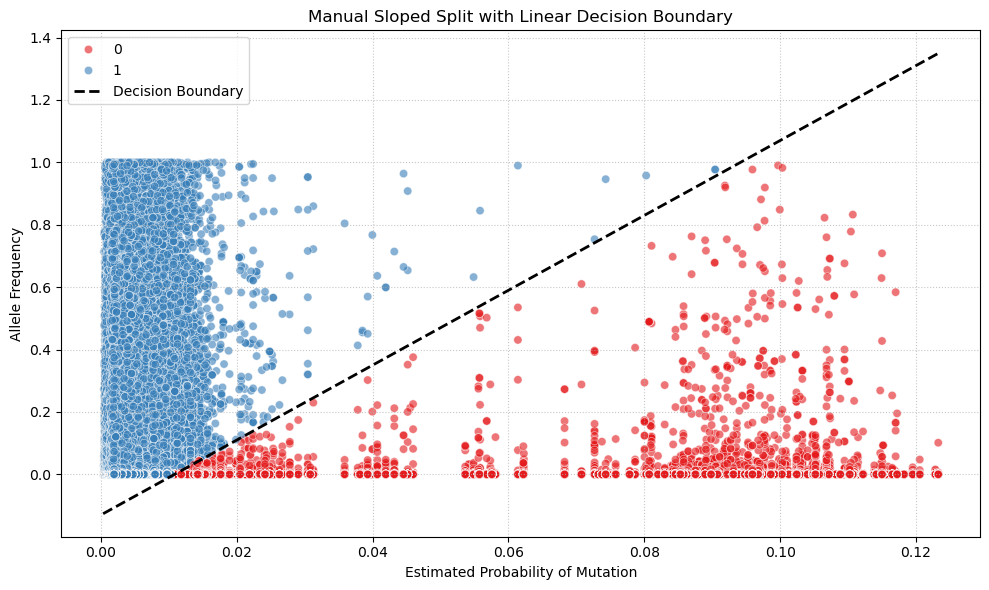

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define your slope and intercept
a = 12  # example slope
b = -0.13  # example intercept

# Compute the decision boundary
boundary = a * merged_neutral['estimated_p_mutated'] + b
merged_neutral['cluster'] = (merged_neutral['AF'] > boundary).astype(int)

# Plot the scatter and boundary line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_neutral, x='estimated_p_mutated', y='AF', hue='cluster', palette='Set1', alpha=0.6)

# Plot the decision boundary line
x_vals = np.linspace(merged_neutral['estimated_p_mutated'].min(), merged_neutral['estimated_p_mutated'].max(), 100)
y_vals = a * x_vals + b
plt.plot(x_vals, y_vals, color='black', linestyle='--', linewidth=2, label='Decision Boundary')

# Final formatting
plt.title('Manual Sloped Split with Linear Decision Boundary')
plt.xlabel('Estimated Probability of Mutation')
plt.ylabel('Allele Frequency')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 3. Fit linear regression models for each cluster
models = {}
colors = ['blue', 'green']
plt.figure(figsize=(10, 6))

for cluster_id in [0, 1]:
    sub_df = merged_neutral[merged_neutral['cluster'] == cluster_id]
    X = sub_df[['estimated_p_mutated']]
    y = sub_df['AF']
    
    model = LinearRegression()
    model.fit(X, y)
    models[cluster_id] = model
    
    # Scatter plot
    sns.scatterplot(x=X['estimated_p_mutated'], y=y, label=f'Cluster {cluster_id}', alpha=0.6)
    
    # Regression line
    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_vals = model.predict(x_vals)
    plt.plot(x_vals, y_vals, linestyle='--', linewidth=2, color=colors[cluster_id], label=f'Regression Line {cluster_id}')

merged_neutral["adapted_cluster_reg"] = merged_neutral.apply(
    lambda r: models[r["cluster"]].predict([[r["estimated_p_mutated"]]])[0],
    axis=1
)

# 4. Formatting
plt.title('Two Linear Regressions by Manual Sloped Cluster Assignment')
plt.xlabel('Estimated Probability of Mutation')
plt.ylabel('Allele frequency')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Print model coefficients
for cluster_id, model in models.items():
    print(f"Cluster {cluster_id}: Intercept = {model.intercept_:.4f}, Coefficient = {model.coef_[0]:.4f}")

/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


NameError: name 'merged' is not defined

Error in callback <function _draw_all_if_interactive at 0x7f3569840dc0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1.  SCATTER OF PREDICTION  vs  OBSERVATION -----------------------------
plt.figure(figsize=(10, 6))

# Make sure you pass 1‑D Series, not DataFrames
plt.scatter(
    merged['adapted_cluster_reg'],   # x‑axis = your calibrated prediction
    merged['var_freq'],           # y‑axis = the observed rate
    alpha=0.2
)

# --- 2.  BEST‑FIT (CALIBRATION) LINE USING NUMPY.polyfit ---------------------
m, b = np.polyfit(                   # degree‑1 = straight line
    merged['adapted_cluster_reg'],
    merged['var_freq'],
    1
)

# grab the current axis limits so the line spans the whole plot
x_vals = np.array(plt.gca().get_xlim())
y_vals = m * x_vals + b

plt.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=2,
         label=f'Regression Line')

# --- 3.  A LITTLE POLISH -----------------------------------------------------
plt.xlabel('Adapted regression prediction')
plt.ylabel('Variation Frequency')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
merged_df.to_csv("/s/project/ml4rg_students/2025/project07/group_2/data/neutral_model_adapted_final.csv")